Graph Constrained Unmixing w/ Normalized Cuts

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from SuperpixelCutsPy import *
import scipy as sp
# Configs for Notebooks
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(suppress=True)

In [2]:
h5_import = h5py.File("data/samson_abc.h5",'r+').get('samson_a')
hyperspectral_cube = np.array(h5_import)
nx,ny,nb = hyperspectral_cube.shape
del h5_import

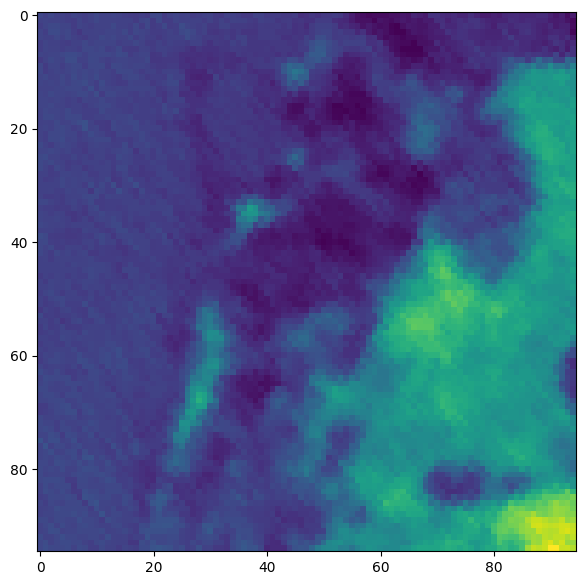

In [3]:
plt.imshow(hyperspectral_cube[:,:,1]);

In [4]:
preprocessing_pipeline = Preprocesser.Preprocesser(data = hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 0)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()

In [5]:
n_superpixels = 1000 #2500
slic_m_param = 3    #2
assignments, centers = superpixel.generate_SLIC_assignments(data = hyperspectral_cube,
                                                            n_superpixels = n_superpixels,
                                                            slic_m_param = slic_m_param)
superpixeled_cube, superpixel_library = superpixel.generate_SLIC_superpixels(data = hyperspectral_cube,
                                                                             assignments = assignments)
n_superpixels = len(np.unique(assignments))

Adjusting n_superpixels: 961
Created 961 superpixels


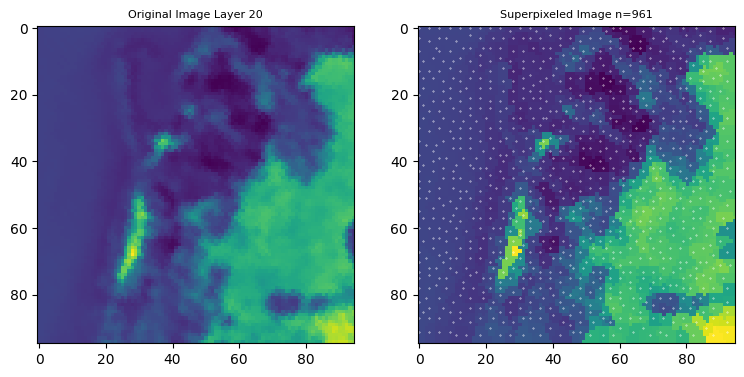

In [6]:
fig, ax = plt.subplots(1,2, dpi=100);
layer_preview = 20
ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
ax[1].imshow(superpixeled_cube[:,:,layer_preview])
ax[1].scatter(centers[:,1], centers[:,0], c='white', s=0.1);
ax[0].set_title(f'Original Image Layer {layer_preview}', fontsize = 8);
ax[1].set_title(f'Superpixeled Image n={len(np.unique(assignments))}', fontsize = 8);

In [7]:
sigma_param = 0.015 # 0.1 -> 0.001           #0.01
spatial_limit = 30# 15 -> 25 in steps of 5 #15
spatial_beta_param = 0.005
spatial_dmax_param =  spatial_limit #10
ne = 3#number of endmembers

labelled_img, normalized_signatures, int_results = normalized_cuts.graph_regularized_ncuts_admm(data=hyperspectral_cube,
                                                                                                superpixel_library=superpixel_library,
                                                                                                superpixel_centers=centers,
                                                                                                superpixel_assignments=assignments,
                                                                                                n_endmembers = ne,
                                                                                                spectral_sigma2_param= sigma_param,
                                                                                                spatial_kappa_param=spatial_limit,
                                                                                                spatial_beta_param= spatial_beta_param,
                                                                                                spatial_dmax_param = spatial_dmax_param,
                                                                                                n_unmixing_iters = 200,
                                                                                                spectral_metric='SAM')

original_library  = segmentation_evaluation.calc_mean_label_signatures(utility.cube_to_matrix(original_hyperspectral_cube),
                                                                        labelled_img.reshape(-1))

#original_library = segmentation_evaluation.calc_mean_label_signatures(superpixel_original_library, superpixel_cluster_labels)

Initial Clustering
Spectral + Unmixing Clustering


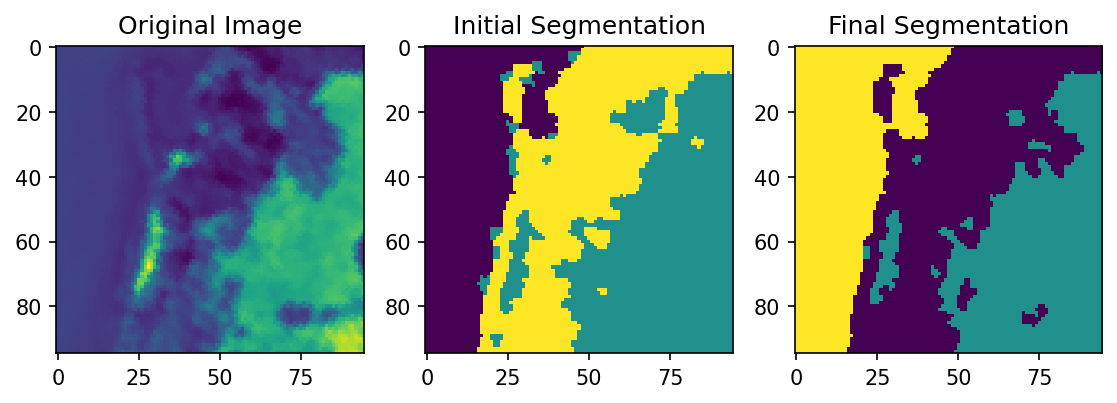

In [8]:
fig, ax = plt.subplots(1,3, dpi=150);
ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
ax[1].imshow(int_results['initial_labels']);
ax[2].imshow(labelled_img);

ax[0].set_title("Original Image");
ax[1].set_title("Initial Segmentation");
ax[2].set_title("Final Segmentation");

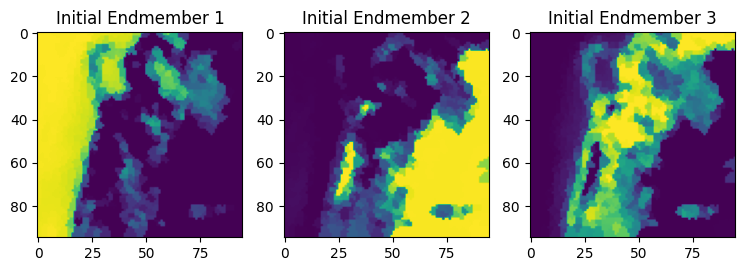

In [9]:
num_layers = min(int_results['abundance_results'].shape[2], ne)

fig, axes = plt.subplots(1, num_layers, figsize=(ne*num_layers, ne))

for i in range(num_layers):
    axes[i].imshow(int_results['abundance_results'][:, :, i], cmap='viridis')
    axes[i].set_title(f'Initial Endmember {i+1}')

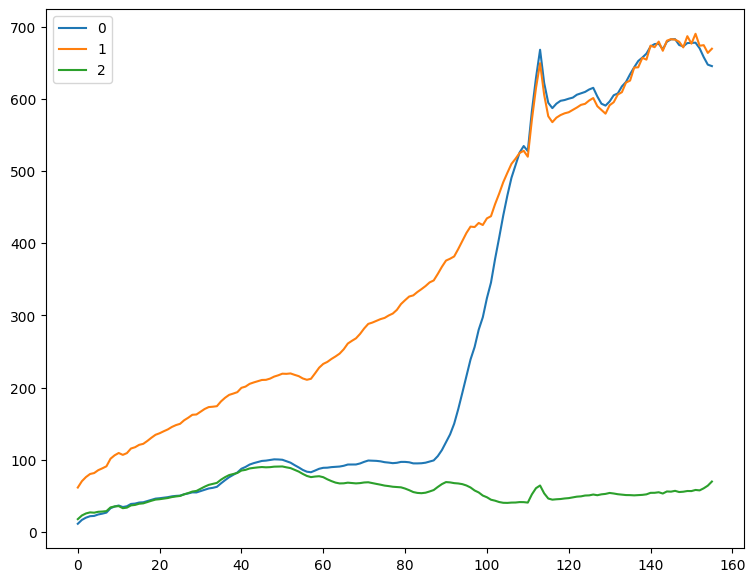

In [10]:
plt.plot(original_library);
plt.legend(np.arange(ne));

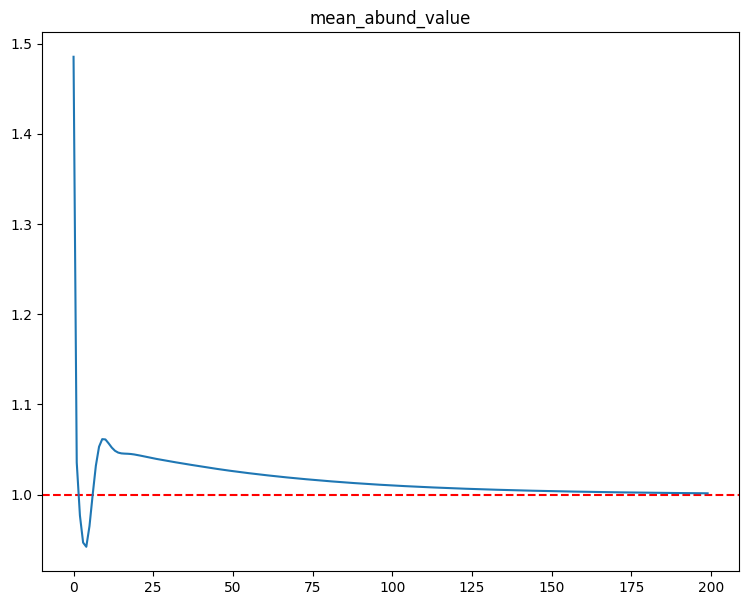

In [11]:
#dict_keys(['loss', 'primal_residual', 'dual_residual', 'mean_abund_value', 'n_iters'])
view = 'mean_abund_value'
plt.axhline(y=1, color='r', linestyle='--');
plt.plot(int_results['unmixing_history'][view]);
plt.title(view);

In [34]:
dataset_name = 'samson_a'
savefigs = True
if savefigs:
    print("Saving Original Image")
    utility.save_hcube(hyperspectral_cube = original_hyperspectral_cube,
                       n_layers = 50,
                       output_img=f'display_imgs/{dataset_name}_original.png');

    print("Saving Preprocessed Results")
    utility.save_hcube(hyperspectral_cube = hyperspectral_cube,
                   n_layers = 50,
                   output_img=f'display_imgs/{dataset_name}_preprocessed.png');

    print("Saving Superpixel Results")
    utility.save_hcube(hyperspectral_cube = superpixeled_cube,
                   n_layers = 50,
                   output_img=f'display_imgs/{dataset_name}_superpixeled.png');

    print("Saving Abundance Results")
    utility.save_hcube(hyperspectral_cube = int_results['abundance_results'],
                   n_layers = ne,
                   output_img=f'display_imgs/{dataset_name}_abundances.png');

    print("Saving Abundance + Superpixel Results")
    step_size = 8
    utility.save_hcube(hyperspectral_cube = np.concatenate([superpixeled_cube[:,:,np.arange(0, nb, step_size)],
                                                            int_results['abundance_results']], axis = 2),
                      n_layers = np.arange(0, nb, step_size).shape[0] + ne,
                      output_img=f'display_imgs/{dataset_name}_superpixel_plus_abudance.png');

    print("Saving Segmentation Results")
    utility.save_img(image = int_results['initial_labels'],
                     output_img= f'display_imgs/{dataset_name}_initial_segmentation.png')

    utility.save_img(image = labelled_img,
                     output_img= f'display_imgs/{dataset_name}_final_segmentation.png')
    
    fig, ax = plt.subplots(ne,2, figsize = (ne+2,2*ne), dpi=150);
    for k in range(ne):
        ax[k,0].set_title(f'Initial Segment {k+1}', fontsize = 6)
        ax[k,0].imshow(int_results['initial_labels'] == k, cmap = 'gray');
        ax[k,0].set_xticks([]);
        ax[k,0].set_yticks([]);
        ax[k,1].set_title(f'Segment {k+1} Normalized Signature', fontsize = 6);
        ax[k,1].plot(int_results['initial_spectra'][:,k]);
        ax[k,1].set_ylim(0,1);  
    fig.text(0.7, 0, 'Band Index', fontsize = 8, ha='center')
    fig.text(1, 0.5, 'Reflectance Intensity', fontsize = 8, va='center', rotation='vertical')
    plt.tight_layout();
    fig.patch.set_alpha(0);
    plt.savefig(f'display_imgs/{dataset_name}_initial_segmentation_signatures.png', bbox_inches='tight');
    plt.close();


Saving Original Image
Saving Preprocessed Results
Saving Superpixel Results
Saving Abundance Results
Saving Abundance + Superpixel Results
Saving Segmentation Results


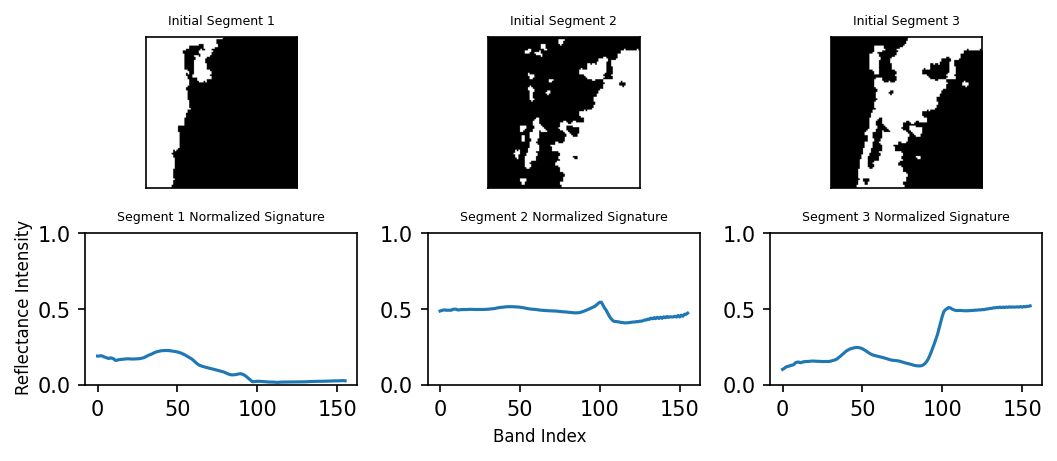

In [15]:
    # fig, ax = plt.subplots(2,ne, figsize = (2*ne+1,ne), dpi=150);
    # for k in range(ne):
    #     ax[0,k].set_title(f'Initial Segment {k+1}', fontsize = 6)
    #     ax[0,k].imshow(int_results['initial_labels'] == k, cmap = 'gray');
    #     ax[0,k].set_xticks([]);
    #     ax[0,k].set_yticks([]);
    #     ax[1,k].set_title(f'Segment {k+1} Normalized Signature', fontsize = 6);
    #     ax[1,k].plot(int_results['initial_spectra'][:,k]);
    #     # ax[1,k].set_ylim(0,1);  
    # plt.tight_layout();
    # fig.text(0.5, 0, 'Band Index', fontsize = 8, ha='center')
    # fig.text(0, 0.3, 'Reflectance Intensity', fontsize = 8, va='center', rotation='vertical')
    # fig.patch.set_alpha(0);
    # # plt.savefig(f'display_imgs/{dataset_name}_initial_segmentation_signatures.png');
    # # plt.close();

In [33]:
fig, ax = plt.subplots(ne,2, figsize = (ne+2,2*ne), dpi=150);
for k in range(ne):
    ax[k,0].set_title(f'Initial Segment {k+1}', fontsize = 6)
    ax[k,0].imshow(int_results['initial_labels'] == k, cmap = 'gray');
    ax[k,0].set_xticks([]);
    ax[k,0].set_yticks([]);
    ax[k,1].set_title(f'Segment {k+1} Normalized Signature', fontsize = 6);
    ax[k,1].plot(int_results['initial_spectra'][:,k]);
    ax[k,1].set_ylim(0,1);  
fig.text(0.7, 0, 'Band Index', fontsize = 8, ha='center')
fig.text(1, 0.5, 'Reflectance Intensity', fontsize = 8, va='center', rotation='vertical')
plt.tight_layout();
fig.patch.set_alpha(0);
plt.savefig(f'test.png', bbox_inches='tight');
plt.close();